# A gentle practical intro to adversarial ML

In this tutorial we will train a convolutional neural network and we will show how we can fool the network perturbing an image.

## AML with images

First, we will load all the necessary libraries

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

torch.manual_seed(1234)
np.random.seed(1234)
import warnings
warnings.filterwarnings("ignore")

Our model will be a simple convolutional network

In [2]:
class SimpleCNN(nn.Module):
    """ Basic MNIST model
    """

    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64 * 7 * 7)  # reshape Variable
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

We may explore the architecture

In [3]:
cnn = SimpleCNN()
cnn

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

With the help of https://github.com/szagoruyko/pytorchviz we will visualize the network

In [4]:
from torchviz import make_dot

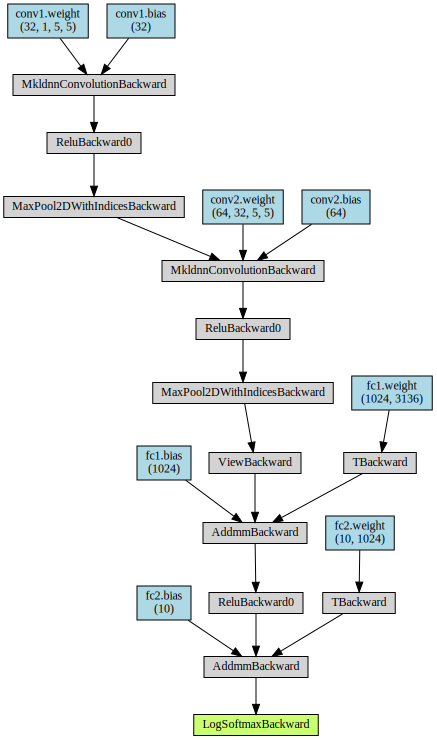

In [5]:
random_input = (torch.randn([1, 1, 28, 28]))

make_dot(cnn(random_input), params=dict(cnn.named_parameters()))

Now we define the hyperparameters

In [6]:
n_epochs = 6
batch_size = 128
lr = .001

In [8]:
torch_model = SimpleCNN()

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size)

0it [00:00, ?it/s]

100%|█████████▉| 9895936/9912422 [00:20<00:00, 465606.19it/s] 

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



0it [00:00, ?it/s]


 57%|█████▋    | 16384/28881 [00:00<00:00, 132447.54it/s]
32768it [00:00, 64353.78it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



 99%|█████████▉| 1630208/1648877 [00:04<00:00, 355701.73it/s]
1654784it [00:04, 341097.69it/s]                             
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]
8192it [00:00, 32527.68it/s]            

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


9920512it [00:40, 465606.19it/s]                             

Now we are ready for training the model

In [14]:
# Training
optimizer = optim.Adam(torch_model.parameters(), lr=lr)
train_loss = []

total = 0
correct = 0
step = 0
for epoch in range(n_epochs):
    for xs, ys in train_loader:

        optimizer.zero_grad()
        
        # Compute predictions
        preds = torch_model(xs)
        loss = F.nll_loss(preds, ys)
        
        # Compute gradients (backpropagation)
        loss.backward()  
        train_loss.append(loss.data.item())
        
        # Update parameters
        optimizer.step()  

        correct += (torch.argmax(preds, axis=1) == ys).sum()
        total += len(xs)
        step += 1
        if total % 1000 == 0:
            acc = float(correct) / total
            print('[%s] Training accuracy: %.2f%%' % (step, acc * 100))
            total = 0
            correct = 0

KeyboardInterrupt: 

In [17]:
# torch.save(torch_model.state_dict(), 'cnn_weights.bin')

For this tutorial, instead of waiting for training to finish, we will just load some pretrained weights

In [15]:
torch_model = SimpleCNN()
torch_model.load_state_dict(torch.load('cnn_weights.bin'))

<All keys matched successfully>

We evaluate over a clean test set (without attacking)

In [19]:
total = 0
correct = 0
for xs, ys in test_loader:

    preds = torch_model(xs)
    preds_np = preds.data.cpu().numpy()

    correct += (torch.argmax(preds, axis=1) == ys).sum()
    total += len(xs)

acc = float(correct) / total
print('[%s] Clean accuracy: %.2f%%' % (step, acc * 100))

[9] Clean accuracy: 99.11%


## Evaluating our classifier under adversarial attacks

Now, we will study the famous attack *fast gradient sign method* (FGSM), one of the first successful attacks against deep neural networks. It was introduced by Goodfellow et al in 2014 https://arxiv.org/abs/1412.6572

The main idea is to slightly perturb an original image $x$ following the sign of the gradient of the loss $\mathcal{L}$:

$$
x' = x + \epsilon \mbox{sign}(\nabla_x \mathcal{L}(x,y,\theta))
$$

We will do it over an example

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

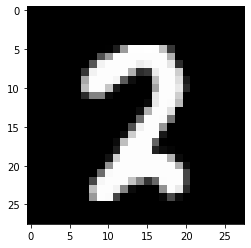

In [22]:
idx = 1
sample = xs[idx]
plt.imshow(sample.numpy()[0,:,:], cmap='gray')

In [25]:
sample.requires_grad = True
output = torch_model(sample.unsqueeze(0))
print('Predicted class:', torch.argmax( output ).numpy())

Predicted class: 2


The previous example was correctly classified. Let's see what happens under the FGSM attack

In [26]:
# Gradient computation
F.nll_loss(output, ys[idx].unsqueeze(0)).backward()

Now, we have just computed $\nabla_x \mathcal{L}(x,y,\theta)$:

In [27]:
sample.grad.shape

torch.Size([1, 28, 28])

We will apply the FGSM attack:

In [28]:
adv_sample = sample + 0.1*torch.sign(sample.grad)

In [31]:
adv_output = torch_model(adv_sample.unsqueeze(0))
print('Predicted class:', torch.argmax( adv_output ).numpy())

Predicted class: 7


It seems we have fool our classifier. What is the visual aspect of the attacked input?

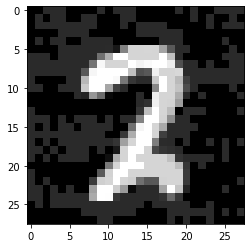

In [30]:
plt.imshow(adv_sample.detach().numpy()[0,:,:], cmap='gray')

This doesn't look as a 7...

Can you compute the accuracy over the whole attacked test set?